# Solving 1D Saint-Venant usinf physics informed neural networks

# Problem Definition

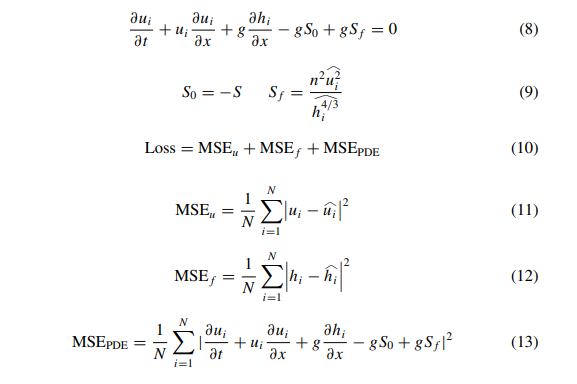

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [49]:
# Define the neural network model

g= 9.81 # m/s^2

class SaintVenantPINN(tf.keras.Model):
    def __init__(self):
        super(SaintVenantPINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(units=50, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=50, activation='relu')
        self.dense3 = tf.keras.layers.Dense(units=50, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(units=2)  # Two outputs: h (depth), u (velocity)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.output_layer(x)

# Instantiate the model
model = SaintVenantPINN()

In [50]:
def saint_venant_pde(x, t, model):
  with tf.GradientTape(persistent = True) as tape1:
    # tape1.watch([x, t])
    tape1.watch(x)
    tape1.watch(t)
    inputs = tf.concat([x, t], axis = 1)
    h_u = model(inputs) # Predict h and u
    h, u = h_u[:, 0:1], h_u[:, 1:2]

    # Discharge = h * u
    q = h * u

  # Compute first-order derivatives
  dh_dx = tape1.gradient(h, x)
  dh_dt = tape1.gradient(h, t)
  du_dx = tape1.gradient(u, x)
  du_dt = tape1.gradient(u, t)



  # Derivative of q
  dq_dx = tape1.gradient(q, x)
  dq_dt = tape1.gradient(q, t)

  del tape1

  # Continuity equation residual: dh/dt + d(hu)/dx = 0
  continuity_residual = dh_dt + dq_dx

  # Momentum equation residual: du/dt + u * du/dx + g * dh/dx = 0
  momentum_residual = du_dt + u*du_dx + g*dh_dx

  return continuity_residual, momentum_residual


In [51]:
# Define loss function

def loss(model, x_train, t_train, x_bc, t_bc, h_bc, u_bc):
  con_res, mom_res = saint_venant_pde(x_train, t_train, model)
  # compute the mean squared error of the boundry conditions
  loss_pde = tf.reduce_mean(tf.square(con_res)) + tf.reduce_mean(tf.square(mom_res))

  # boundry condition loss
  h_u_bc_pred = model(tf.concat([x_bc, t_bc], axis = 1))
  h_bc_pred, u_bc_pred = h_u_bc_pred[:, 0:1], h_u_bc_pred[:, 1:2]
  loss_bc = tf.reduce_mean(tf.square(h_bc - h_bc_pred)) + tf.reduce_mean(tf.square(u_bc - u_bc_pred))

  return loss_pde + loss_bc

In [52]:
# Training step

def train_step(model, x_train, t_train, x_bc, t_bc, h_bc, u_bc, optimizer):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x_train, t_train, x_bc, t_bc, h_bc, u_bc)

    # called_model = call_model(model, tf.concat([x_train, t_train], axis = 1))
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

In [53]:
# Setting up the problem

# Generate training data
x_train = np.linspace(0, 10, 100).reshape(-1, 1)  # 100 spatial points
t_train = np.linspace(0, 5, 100).reshape(-1, 1)   # 100 time points

# Convert to TensorFlow tensors
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
t_train = tf.convert_to_tensor(t_train, dtype=tf.float32)

# Boundary conditions (at x=0 and x=10)
x_bc = np.array([[0.0], [10.0]], dtype=np.float32)  # Locations
t_bc = np.array([[0.0], [0.0]], dtype=np.float32)   # Time at initial condition
h_bc = np.array([[2.0], [1.0]], dtype=np.float32)   # Water depth: h(0,0) = 2m, h(10,0) = 1m
u_bc = np.array([[0.0], [0.0]], dtype=np.float32)   # Velocity: Initially zero

# Convert to TensorFlow tensors
x_bc = tf.convert_to_tensor(x_bc, dtype=tf.float32)
t_bc = tf.convert_to_tensor(t_bc, dtype=tf.float32)
h_bc = tf.convert_to_tensor(h_bc, dtype=tf.float32)
u_bc = tf.convert_to_tensor(u_bc, dtype=tf.float32)

# Define the optimizer with learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-3,
    decay_steps = 500,
    decay_rate = 0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

In [54]:
# Train the model

epochs = 1000
for epoch in range(epochs):
    loss_value = train_step(model, x_train, t_train, x_bc, t_bc, h_bc, u_bc, optimizer)
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value.numpy()}")

Epoch 0, Loss: 3.3444223403930664
Epoch 50, Loss: 0.9013333320617676
Epoch 100, Loss: 0.1032114028930664
Epoch 150, Loss: 0.009604751132428646
Epoch 200, Loss: 0.0055489307269454
Epoch 250, Loss: 0.003090361598879099
Epoch 300, Loss: 0.00429508974775672
Epoch 350, Loss: 0.00313443667255342
Epoch 400, Loss: 0.002179451985284686
Epoch 450, Loss: 0.004297600127756596
Epoch 500, Loss: 0.004860165063291788
Epoch 550, Loss: 0.0018795231590047479
Epoch 600, Loss: 0.0009393681539222598
Epoch 650, Loss: 0.0028477786108851433
Epoch 700, Loss: 0.0012972818221896887
Epoch 750, Loss: 0.0009837067918851972
Epoch 800, Loss: 0.0005652595427818596
Epoch 850, Loss: 0.0007949468563310802
Epoch 900, Loss: 0.0006930052186362445
Epoch 950, Loss: 0.005803354550153017


In [55]:
# Predict solution
x_test = np.linspace(0, 10, 100).reshape(-1, 1)
t_test = np.linspace(0, 5, 100).reshape(-1, 1)

x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
t_test = tf.convert_to_tensor(t_test, dtype=tf.float32)



# Analytical Solution
h_u_pred = model(tf.concat([x_test, t_test], axis=1)).numpy()
h_pred, u_pred = h_u_pred[:, 0], h_u_pred[:, 1]

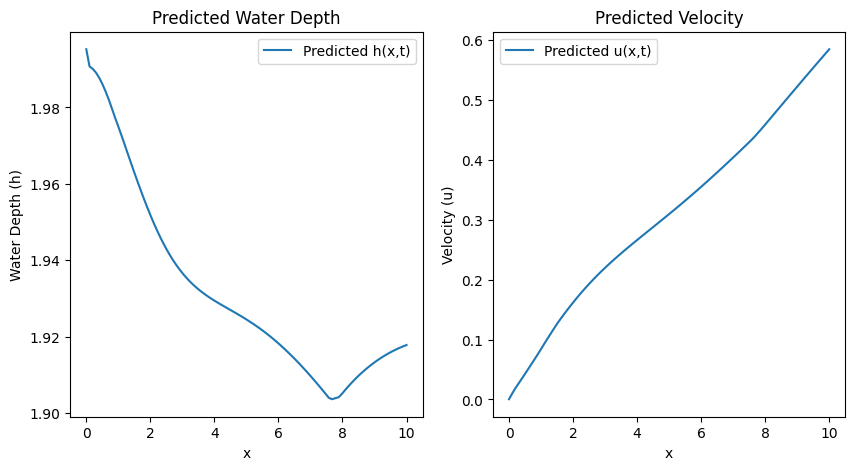

In [57]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_test.numpy(), h_pred, label="Predicted h(x,t)")
plt.xlabel("x")
plt.ylabel("Water Depth (h)")
plt.title("Predicted Water Depth")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_test.numpy(), u_pred, label="Predicted u(x,t)")
plt.xlabel("x")
plt.ylabel("Velocity (u)")
plt.title("Predicted Velocity")
plt.legend()

plt.show()